# HadCRUT5 ML Experiment

## Setup

In [1]:
import os
import joblib
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import cartopy.crs as ccrs
from sklearn.metrics import mean_squared_error

In [2]:
# Some styling parameters. 
plt.style.use("fivethirtyeight")
plt.rcParams['lines.linewidth'] = 1
pd.set_option("display.float_format", "{:.2f}".format)
scatter_size = 4
scatter_alpha = 0.3
figsize = (15, 6)
titlesize = 14
labelsize = 12
cmap = "seismic"

## Load Data

In addition to the HadCRUT5 ensemble, a mean file is available that contains fields of the mean anomaly from the 200 ensemble members in each grid box. The 200 member HadCRUT5 ensemble has been constructed to allow exploration of the sensitivity of scientific analyses to the estimated uncertainties. If only the mean is used it will not be possible to explore the sensitivity to these uncertainties. 

**Manual Approach**
* Data used - HadCRUT5 analysis gridded data: additional fields: HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc
* Webpage: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/download.html
* Download link: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/analysis/HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc
* This could be useful if the url / file names are changed in the future.

**Automated Approach**
* Or, run the code in the next cell to download, save and extract the data automatically.

In [3]:
file_path = "data/HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc"

# Check if the file has already been downloaded, if not run the download_data.py script. 
if not os.path.exists(file_path):
    !python download_data.py

The dataset has dimensions of time, latitude and longitude. <br>
The dataset contains a data variable of "tas_mean" representing monthly temperature anomalies using Kelvin as the unit. 

In [4]:
# Use Xarray to open and store the dataset.
dataset = xr.open_dataset(file_path)
dataset

<xarray.Dataset> Size: 43MB
Dimensions:           (time: 2095, latitude: 36, longitude: 72, bnds: 2)
Coordinates:
  * time              (time) datetime64[ns] 17kB 1850-01-16T12:00:00 ... 2024...
  * latitude          (latitude) float64 288B -87.5 -82.5 -77.5 ... 82.5 87.5
  * longitude         (longitude) float64 576B -177.5 -172.5 ... 172.5 177.5
    realization       int64 8B ...
Dimensions without coordinates: bnds
Data variables:
    tas_mean          (time, latitude, longitude) float64 43MB ...
    time_bnds         (time, bnds) datetime64[ns] 34kB ...
    latitude_bnds     (latitude, bnds) float64 576B ...
    longitude_bnds    (longitude, bnds) float64 1kB ...
    realization_bnds  (bnds) int64 16B ...
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      Data set built at: 2024-09-02T14:38:01+00:00
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.2.0 HadSST.4.0.1.0
    title:        HadCRUT.5.0.2.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.2.0
    Conventions:  CF-1.7

In [5]:
# Check the variable unit type. 
dataset.tas_mean.units

'K'

In this Machine Learning demo we will explore Xarray's .to_dataframe() method which enables us to convert a multidimensional Xarray dataset to a Pandas Dataframe. If you are new to working with multidimensional data, this might provide an option to get started working with netcdf and other multidimensional dataset files. 

In [6]:
# Convert the Xarray dataset to a Pandas DataFrame.
df = dataset.to_dataframe()

In [7]:
df

tas_mean  time_bnds  \
time                latitude longitude bnds                        
1850-01-16 12:00:00 -87.50   -177.50   0          NaN 1850-01-01   
                                       1          NaN 1850-02-01   
                             -172.50   0          NaN 1850-01-01   
                                       1          NaN 1850-02-01   
                             -167.50   0          NaN 1850-01-01   
...                                               ...        ...   
2024-07-16 12:00:00 87.50    167.50    1         1.19 2024-08-01   
                             172.50    0         1.18 2024-07-01   
                                       1         1.18 2024-08-01   
                             177.50    0         1.16 2024-07-01   
                                       1         1.16 2024-08-01   

                                             latitude_bnds  longitude_bnds  \
time                latitude longitude bnds                                  
1850-01-16 12:00:00 -87.50   -177.50   0            -90.00         -180.00   
                                       1            -85.00         -175.00   
                             -172.50   0            -90.00         -175.00   
                                       1            -85.00         -170.00   
                             -167.50   0            -90.00         -170.00   
...                                                    ...             ...   
2024-07-16 12:00:00 87.50    167.50    1             90.00          170.00   
                             172.50    0             85.00          170.00   
                                       1             90.00          175.00   
                             177.50    0             85.00          175.00   
                                       1             90.00          180.00   

                                             realization  realization_bnds  
time                latitude longitude bnds                                 
1850-01-16 12:00:00 -87.50   -177.50   0             100                 1  
                                       1             100               200  
                             -172.50   0             100                 1  
                                       1             100               200  
                             -167.50   0             100                 1  
...                                                  ...               ...  
2024-07-16 12:00:00 87.50    167.50    1             100               200  
                             172.50    0             100                 1  
                                       1             100               200  
                             177.50    0             100                 1  
                                       1             100               200  

[10860480 rows x 6 columns]

As you can see above the DataFrame index is a matrix of dimensionality information, including time, latitude and longitude. Lets restructure out dataset.

In [8]:
# Identify the target variable we want to predict
TARGET = "tas_mean"

# Reset the index to convert index levels to columns
df_reset = df.reset_index()

# Now filter the Dataframe to include only the desired columns
feature_columns = ["time", "latitude", "longitude", TARGET]
df = df_reset[feature_columns]
df

,time,latitude,longitude,tas_mean
0,1850-01-16 12:00:00,-87.50,-177.50,NaN
1,1850-01-16 12:00:00,-87.50,-177.50,NaN
2,1850-01-16 12:00:00,-87.50,-172.50,NaN
3,1850-01-16 12:00:00,-87.50,-172.50,NaN
4,1850-01-16 12:00:00,-87.50,-167.50,NaN
...,...,...,...,...
10860475,2024-07-16 12:00:00,87.50,167.50,1.19
10860476,2024-07-16 12:00:00,87.50,172.50,1.18
10860477,2024-07-16 12:00:00,87.50,172.50,1.18
10860478,2024-07-16 12:00:00,87.50,177.50,1.16


<Axes: ylabel='Frequency'>

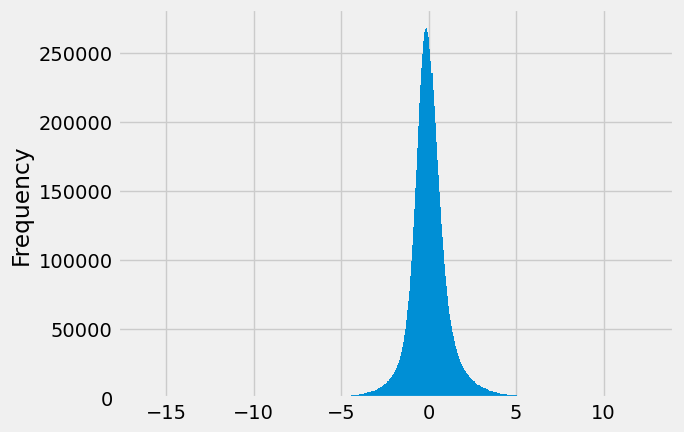

In [9]:
# Visualise the variable distribution. 
df[TARGET].plot(kind="hist", bins=500)

## Null Values

Lets review some of the key information about our dataset. 

In [10]:
df.describe()

,time,latitude,longitude,tas_mean
count,10860480,10860480.00,10860480.00,8661168.00
mean,1937-04-16 17:49:51.694513792,0.00,0.00,0.03
min,1850-01-16 12:00:00,-87.50,-177.50,-16.33
25%,1893-08-16 12:00:00,-43.75,-88.75,-0.55
50%,1937-04-16 00:00:00,0.00,0.00,-0.04
75%,1980-12-16 12:00:00,43.75,88.75,0.52
max,2024-07-16 12:00:00,87.50,177.50,12.61
std,NaN,51.94,103.91,1.25


Lets review how many null values we have in our dataset. As you can see ~20% of the tas values are null and will need removing or filling. 

In [11]:
# Calculate % of null values
(df.isna().sum() / df.shape[0]) * 100

time         0.00
latitude     0.00
longitude    0.00
tas_mean    20.25
dtype: float64

In [12]:
# Lets review our DataFrame shape to check how many values we have. 
df.shape

(10860480, 4)

As we have a high number of values lets drop the null values.

In [13]:
# Drop the null values from the dataset. 
df = df.dropna(subset=[TARGET])

# Check the shape again. 
df.shape

(8661168, 4)

## Visualise Data

It might be beneficial to visualise the data to check for outliers, check the distribution and understand it better. 

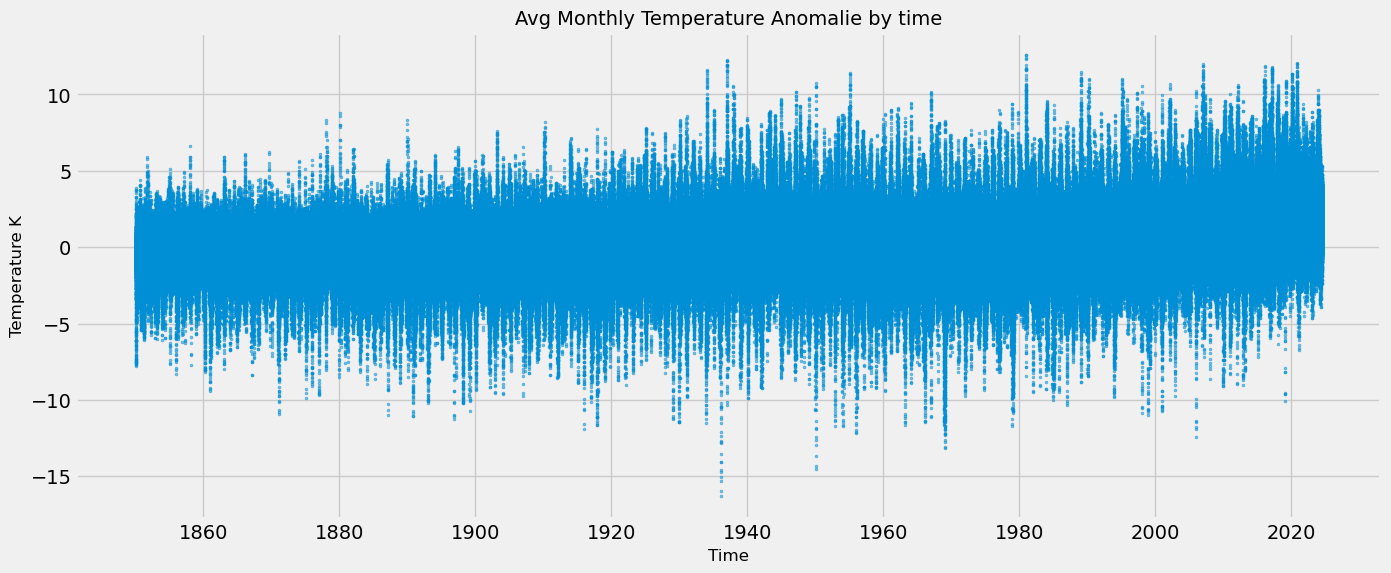

In [14]:
# Visualise the Dataset timeseries. 
plt.figure(figsize=figsize)
plt.scatter(df["time"], df[TARGET], s=scatter_size, alpha=scatter_alpha)
plt.title("Avg Monthly Temperature Anomalie by time", fontsize=titlesize)
plt.xlabel("Time", fontsize=labelsize)
plt.ylabel("Temperature K", fontsize=labelsize)
plt.show()

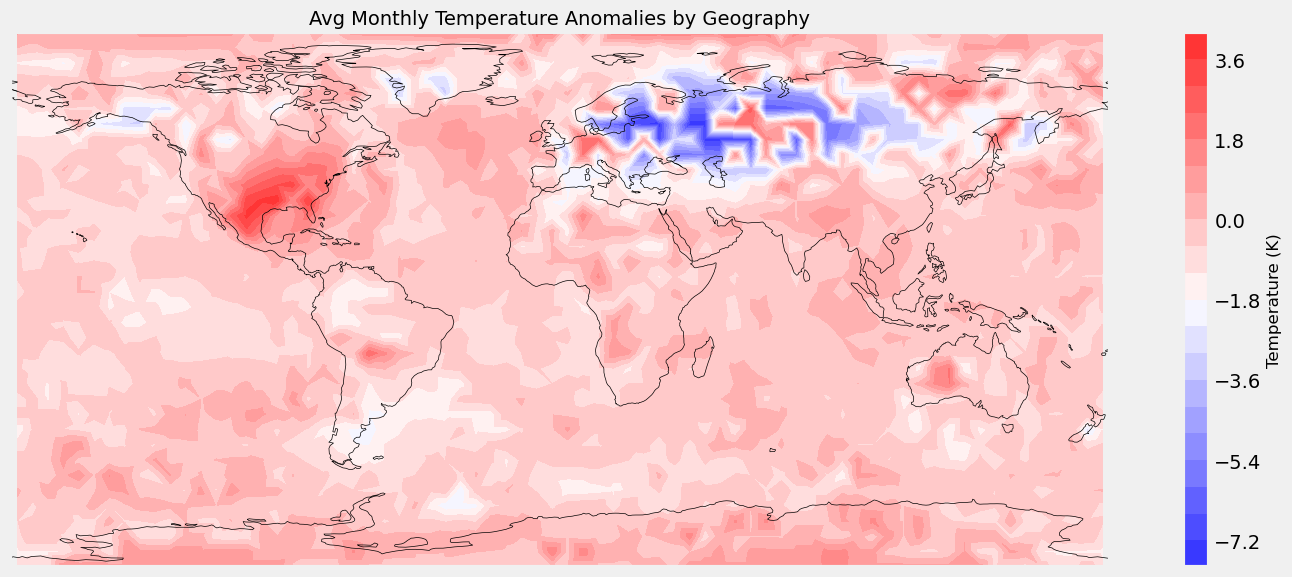

In [15]:
# Set the color limits based on the dataset
min_temp = df[TARGET].min()
max_temp = df[TARGET].max()

fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={"projection": ccrs.PlateCarree()})

# Set the extent and add coastlines for the single plot
ax.set_extent([df.longitude.min(), df.longitude.max(), df.latitude.min(),  df.latitude.max()])  
ax.coastlines()  

# Plot the geographical distribution using tricontourf
contour = ax.tricontourf(df.longitude, df.latitude, df[TARGET], 
                         levels=20, cmap=cmap, vmin=min_temp, vmax=max_temp, transform=ccrs.PlateCarree())

# Set the title, labels, and colorbar
ax.set_title('Avg Monthly Temperature Anomalies by Geography', fontsize=titlesize)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add the colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='vertical')
cbar.set_label('Temperature (K)', fontsize=labelsize)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Time Series

### Set the dataframe index to the time column

In [16]:
# Check time column is of datetime datatype
df.loc[:, "time"] = pd.to_datetime(df["time"])

In [17]:
# Sort dataframe by date
df = df.sort_values(by='time')

In [18]:
# Set the time column to the dataframe index
df = df.set_index("time")
df

,latitude,longitude,tas_mean
time,,,
1850-01-16 12:00:00,-62.50,-112.50,0.11
1850-01-16 12:00:00,37.50,-62.50,1.01
1850-01-16 12:00:00,37.50,-67.50,0.74
1850-01-16 12:00:00,37.50,-67.50,0.74
1850-01-16 12:00:00,37.50,-72.50,0.57
...,...,...,...
2024-07-16 12:00:00,-27.50,-77.50,0.11
2024-07-16 12:00:00,-27.50,-82.50,0.42
2024-07-16 12:00:00,-27.50,-82.50,0.42


### Cut off point

We will reduce the size of the data by cutting off data pre 1950. This will help with the performance of this notebook for running on local machines.

In [19]:
cutoff_date = "1950-01-01"  # Replace with your desired cutoff date
df = df[df.index >= cutoff_date]
df.head(1)

,latitude,longitude,tas_mean
time,,,
1950-01-16 12:00:00,37.50,7.50,0.20


### Train / Test split date

We will split our training data and our test data at a point in time. <br>
This means we will train on the data before this date and then test on the data on and after this date. 

In [20]:
# Choose a date to split on
date_to_split_on = "01-01-2004"

# Create a training DataFrame and assign it to the data before the split date. 
train = df.loc[df.index < date_to_split_on]

# Create a testing DataFrame and assign it to the data on and after the split date. 
test = df.loc[df.index >= date_to_split_on]

# Check the DataFrame shapes
train.shape, test.shape

((3227272, 3), (1270856, 3))

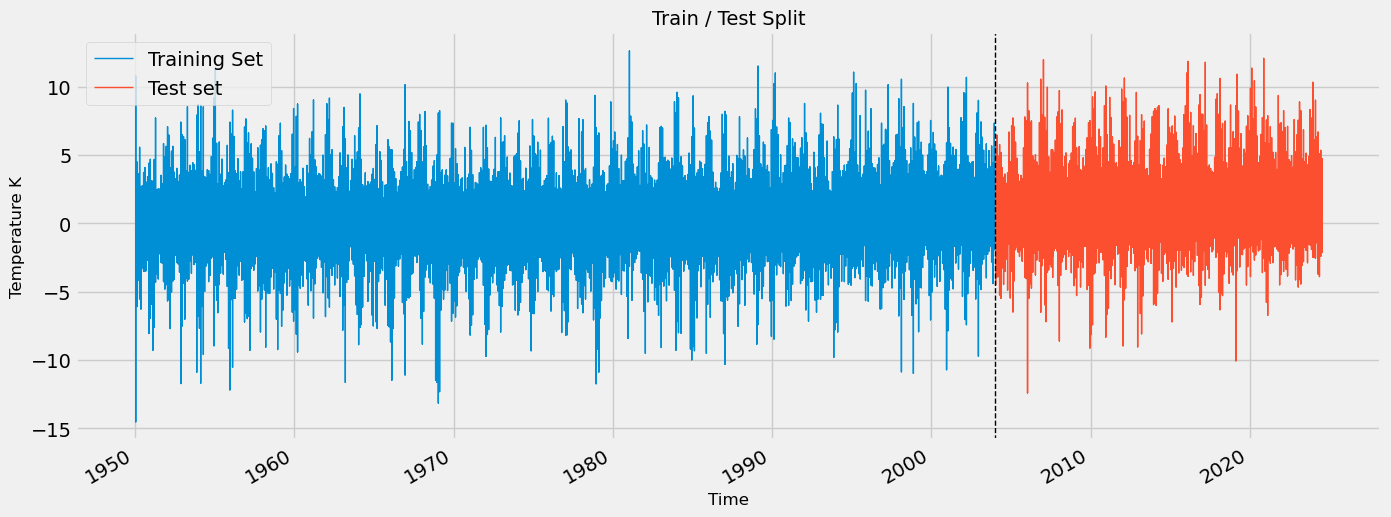

In [21]:
# Visualise the split data

fig, ax = plt.subplots(figsize=figsize)

# Plot the data
train[TARGET].plot(ax=ax, label="Training set")
test[TARGET].plot(ax=ax, label="Test set")

# Set the title 
ax.set_title("Train / Test Split", fontsize=titlesize)  # Adjust the fontsize as needed

ax.axvline(date_to_split_on, color = "black", ls="--")
ax.legend(["Training Set", "Test set"], loc="upper left")

ax.set_xlabel("Time", fontsize=labelsize)
ax.set_ylabel("Temperature K", fontsize=labelsize)

plt.show()

## Feature Creation

We could try and create more data for our model by providing date time information such as the month, quarter and year information and see if this is relevant. 

### Add date features

In [22]:
def create_features(df):
    """
    Create time series features based on time series index
    
    Parameters: 
    Pandas DataFrame where the index is a timeseries
    
    Return: 
    Pandas DataFrame with month, quarter and year features. 
    """
    df = df.copy()                           # Create a copy of the dataframe
    df.loc[:,"month"] = df.index.month       # Create a column called month and extract the month number from the time series index. 
    df.loc[:,"quarter"] = df.index.quarter   # Create a column called quarter and extract the quarter number from the time series index. 
    df.loc[:,"year"] = df.index.year         # Create a column called year and extract the year from the time series index. 
    
    return df


In [23]:
# Call the function to add the month, quarter and year information to our dataframe. 
df = create_features(df)
df.shape

(4498128, 6)

### Add lag features

In [24]:
def add_lag_features(df, lag, num_of_lags):
    """
    Adds lag features to the DataFrame for time series analysis.

    This function creates lagged versions of the 'tas' column in the DataFrame.
    Each lagged column represents the 'tas' value shifted by a multiple of 364 days.

    Parameters:
    df: Pandas DataFrame containing a 'tas' column.
    lag: How long in days to lag the value from the original date. 
    num_of_lags: Assign an amount of lag features to create. 

    Returns:
    Pandas DataFrame with added lag features.
    """
    
    lag = 30    # Assign a lag period in days

    # Loop the number of lag features
    for i in range(1, num_of_lags + 1):  
        # Create a new lag column using the loop index {i} to number it. 
        # Assign a value from tas which has been shifted by the lag amount * loop index.
        df.loc[:,f"lag{i}"] = df.loc[:,"tas_mean"].shift(lag * i)
    
    return df

In [25]:
# Call the add_lag_features function above to add features to the df.
df = add_lag_features(df=df, lag=364, num_of_lags=10)
df

,latitude,longitude,tas_mean,month,quarter,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
time,,,,,,,,,,,,,,,,
1950-01-16 12:00:00,37.50,7.50,0.20,1,1,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-16 12:00:00,37.50,12.50,0.14,1,1,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-16 12:00:00,37.50,2.50,0.07,1,1,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-16 12:00:00,37.50,-2.50,-0.22,1,1,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-16 12:00:00,37.50,2.50,0.07,1,1,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16 12:00:00,-27.50,-77.50,0.11,7,3,2024,0.20,1.06,0.70,0.51,1.17,0.43,0.67,0.96,0.93,0.39
2024-07-16 12:00:00,-27.50,-82.50,0.42,7,3,2024,-0.03,0.93,0.82,0.34,0.75,0.50,0.69,1.20,0.98,0.70
2024-07-16 12:00:00,-27.50,-82.50,0.42,7,3,2024,-0.03,0.93,0.82,0.34,0.75,0.50,0.69,1.20,0.98,0.70


### Check null values.

As you can see from the DataFrame above we have added lag features for most of the DataFrame. However the initial rows have NaN values for these columns. This is becuase there is no prior data to construct the lag values from. <br>

As before, we must remove null values such as these from our data.

In [26]:
df = df.dropna()
df.shape

(4497828, 16)

## Train / Test Split

In [27]:
# We need to update the train / test DataFrames we created earlier following our new features 

train = df.loc[df.index < date_to_split_on]
test = df.loc[df.index >= date_to_split_on]

train.shape, test.shape

((3226972, 16), (1270856, 16))

In [28]:
train

,latitude,longitude,tas_mean,month,quarter,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
time,,,,,,,,,,,,,,,,
1950-01-16 12:00:00,47.50,42.50,-9.30,1,1,1950,0.34,0.61,-0.67,6.87,-0.52,-2.61,-0.98,0.53,-0.72,0.20
1950-01-16 12:00:00,47.50,42.50,-9.30,1,1,1950,1.89,0.96,0.13,6.87,-0.22,2.82,-0.13,0.53,-4.40,0.14
1950-01-16 12:00:00,47.50,37.50,-7.09,1,1,1950,0.34,0.96,-0.18,0.60,-0.22,1.74,-0.13,0.62,0.14,0.07
1950-01-16 12:00:00,47.50,37.50,-7.09,1,1,1950,0.41,-0.16,0.18,8.08,-0.12,0.73,0.07,0.62,1.13,-0.22
1950-01-16 12:00:00,47.50,32.50,-5.76,1,1,1950,0.39,-0.23,0.18,6.99,-0.12,0.73,0.36,0.80,-0.12,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-12-16 12:00:00,-32.50,172.50,0.51,12,4,2003,1.77,-0.12,0.14,0.72,0.65,0.22,0.38,0.64,-0.03,0.89
2003-12-16 12:00:00,-32.50,172.50,0.51,12,4,2003,2.32,0.23,0.14,1.64,0.27,0.53,1.14,0.05,1.02,-0.26
2003-12-16 12:00:00,-32.50,167.50,0.42,12,4,2003,2.32,0.05,0.72,0.32,0.83,0.53,0.38,0.24,0.69,-0.31


Lets identify and store our: 
* **Features** (variables we will train on)
* **Target** (variable we want to predict - also called label).

In [29]:
FEATURES = ["latitude", "longitude", "month", "quarter", "year", "lag1" , "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "lag8", "lag9", "lag10"]

**Lets create our X_train, y_train, X_test and y_test DataFrames.** <br>
Remember our train DataFrame contains data up to the split date and the test DataFrame contains data from the split date. 
* We assign our X_train and X_test our feature columns. 
* We assign our y_train and y_test our target variable column.

In [30]:
# Split the data
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [31]:
X_train

,latitude,longitude,month,quarter,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
time,,,,,,,,,,,,,,,
1950-01-16 12:00:00,47.50,42.50,1,1,1950,0.34,0.61,-0.67,6.87,-0.52,-2.61,-0.98,0.53,-0.72,0.20
1950-01-16 12:00:00,47.50,42.50,1,1,1950,1.89,0.96,0.13,6.87,-0.22,2.82,-0.13,0.53,-4.40,0.14
1950-01-16 12:00:00,47.50,37.50,1,1,1950,0.34,0.96,-0.18,0.60,-0.22,1.74,-0.13,0.62,0.14,0.07
1950-01-16 12:00:00,47.50,37.50,1,1,1950,0.41,-0.16,0.18,8.08,-0.12,0.73,0.07,0.62,1.13,-0.22
1950-01-16 12:00:00,47.50,32.50,1,1,1950,0.39,-0.23,0.18,6.99,-0.12,0.73,0.36,0.80,-0.12,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-12-16 12:00:00,-32.50,172.50,12,4,2003,1.77,-0.12,0.14,0.72,0.65,0.22,0.38,0.64,-0.03,0.89
2003-12-16 12:00:00,-32.50,172.50,12,4,2003,2.32,0.23,0.14,1.64,0.27,0.53,1.14,0.05,1.02,-0.26
2003-12-16 12:00:00,-32.50,167.50,12,4,2003,2.32,0.05,0.72,0.32,0.83,0.53,0.38,0.24,0.69,-0.31


### Scaling our features

We will scale our features. In this case we are using Standardisation as the scaling method, however you could experiment with other techniques such as normalisation (min-max).

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler_X = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train), columns=FEATURES)
X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), columns=FEATURES)

# Check the shapes of the scaled data
X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape

((3226972, 15), (3226972,), (1270856, 15), (1270856,))

In [33]:
X_train_scaled

,latitude,longitude,month,quarter,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
0,0.88,0.40,-1.58,-1.33,-1.76,0.20,0.42,-0.63,5.53,-0.51,-2.21,-0.88,0.35,-0.67,0.09
1,0.88,0.40,-1.58,-1.33,-1.76,1.47,0.71,0.03,5.53,-0.25,2.23,-0.19,0.35,-3.67,0.04
2,0.88,0.35,-1.58,-1.33,-1.76,0.20,0.71,-0.23,0.41,-0.25,1.34,-0.19,0.43,0.03,-0.02
3,0.88,0.35,-1.58,-1.33,-1.76,0.25,-0.21,0.06,6.52,-0.18,0.51,-0.02,0.43,0.85,-0.26
4,0.88,0.30,-1.58,-1.33,-1.76,0.24,-0.26,0.06,5.63,-0.18,0.51,0.22,0.57,-0.18,-0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3226967,-0.69,1.65,1.59,1.34,1.68,1.36,-0.17,0.03,0.51,0.45,0.10,0.23,0.45,-0.11,0.65
3226968,-0.69,1.65,1.59,1.34,1.68,1.82,0.11,0.03,1.26,0.14,0.35,0.85,-0.04,0.76,-0.29
3226969,-0.69,1.60,1.59,1.34,1.68,1.82,-0.04,0.51,0.18,0.60,0.35,0.23,0.12,0.49,-0.33
3226970,-0.69,1.60,1.59,1.34,1.68,1.36,0.66,0.51,-0.04,0.14,0.39,0.27,0.23,0.28,0.45


## Create and Train our XGBoost regression model.

In [34]:
# Define functions to 1) Create the XGBoost model, 2) fit the model to the data, 3) check if the model exists before creating and fitting. 

reg_file_name = "HadCRUT5_XGB_model.pkl"

def create_xgboost_model(n_estimators, early_stopping_rounds, objective, max_depth, learning_rate):
    """
    Create and return an XGBoost regressor model with specified hyperparameters.

    Parameters:
    n_estimators (int): Number of boosting rounds.
    early_stopping_rounds (int): Number of rounds with no improvement to stop training.
    objective (str): Specify the learning task and the corresponding objective function.
    max_depth (int): Maximum depth of a tree.
    learning_rate (float): Boosting learning rate.

    Returns:
    xgb.XGBRegressor: Configured XGBoost regressor model.
    """
    
    reg = xgb.XGBRegressor(base_score=0.5,
                          booster = "gbtree",
                          n_estimators=n_estimators,
                          early_stopping_rounds=early_stopping_rounds, 
                          objective=objective,
                          max_depth=max_depth,
                          learning_rate=learning_rate)
    print("XGBoost regression model created")
    return reg


def fit_xgboost_model(reg):
    """
    Fit the provided XGBoost regressor model to the training data.

    Parameters:
    reg (xgb.XGBRegressor): The XGBoost regressor model to be trained.

    This function fits the model using the scaled training data and evaluates it on both
    the training and test datasets. The evaluation results are printed every 100 rounds.
    """
    reg.fit(X_train_scaled, y_train,
            eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
            verbose=100)
    print("Model fitted")
    

def check_model_exists(reg_file_name):
    """
    Check if a model file exists and load the model if it does.

    Parameters:
    reg_file_name (str): The file name or path of the model to check and load.

    This function checks if the specified model file exists. If it does, the model is loaded
    from the file using joblib.

    Returns:
    An xgboost regression model.
    """
    if os.path.exists(reg_file_name):
        # Load the model from the file
        reg = joblib.load(reg_file_name)
        print("Model found and loaded")
        return reg

    else:
        # Call the create_xgboost_model function to create a regression model.     
        reg = create_xgboost_model(n_estimators=1500, 
                                   early_stopping_rounds=50, 
                                   objective="reg:squarederror",
                                   max_depth=5, 
                                   learning_rate=0.01)
        
        # Call the fit_xgboost_model function and pass the regression model to it. 
        fit_xgboost_model(reg)

        # Save the regression model to a file
        joblib.dump(reg, reg_file_name)
        print("Model saved to file")
        
        return reg


In [35]:
# Call the check_model_exists function to either load a previous model, or create and fit one. 
reg = check_model_exists(reg_file_name)

Model found and loaded


### Visualise Training / Validation loss

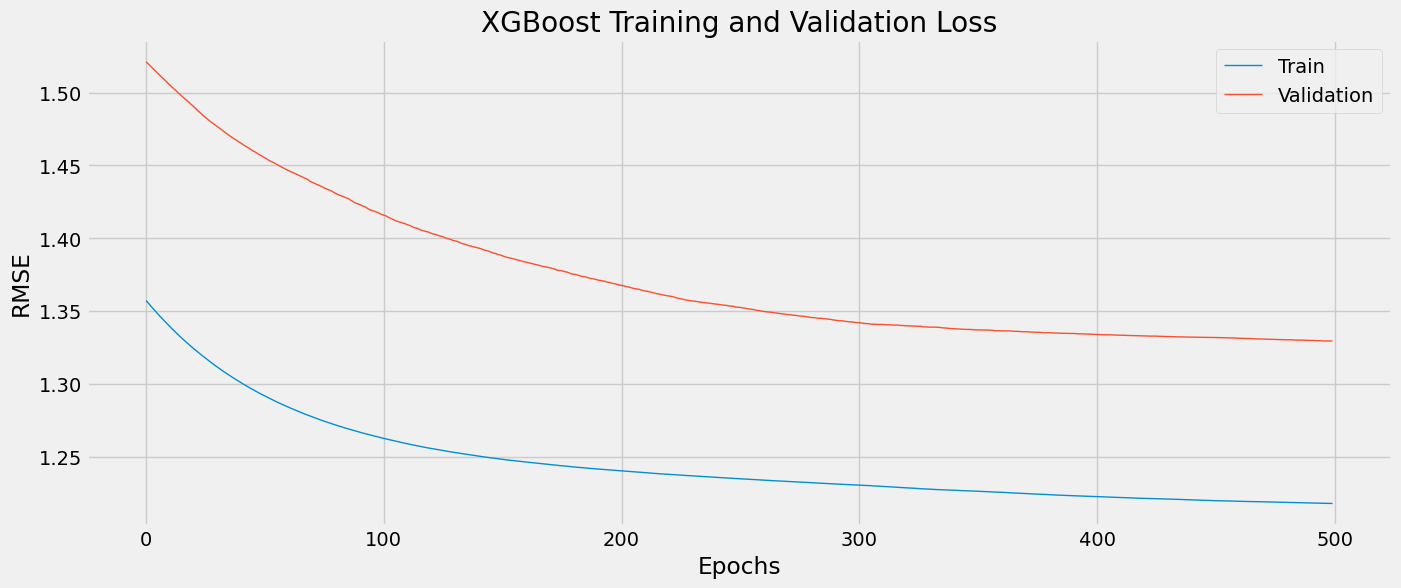

In [36]:
# Plot the loss curves

def loss_curve_graph(reg):

    results = reg.evals_result()
    epochs = len(results["validation_0"]["rmse"])
    x_axis = range(0, epochs)
    
    plt.figure(figsize=figsize)
    plt.plot(x_axis, results["validation_0"]["rmse"], label="Train")
    plt.plot(x_axis, results["validation_1"]["rmse"], label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.title("XGBoost Training and Validation Loss")
    plt.legend()
    plt.show()

loss_curve_graph(reg)

### Feature Importance

Feature importance is a metric used to understand the impact of each feature (or variable) in a predictive model. In the context of machine learning, particularly with models like XGBoost, feature importance helps identify which features contribute the most to the model’s predictions. As we would anticipate lag1 has a higher impact than later lag years. 

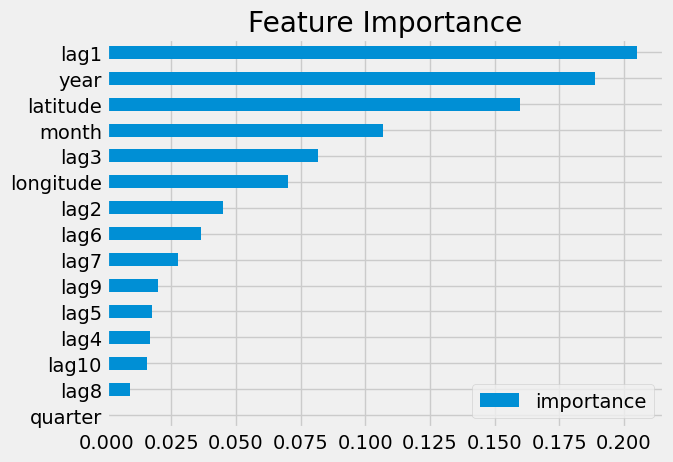

In [37]:
# Create a DataFrame to store the feature importances from the XGBoost model
feature_importance = pd.DataFrame(data=reg.feature_importances_,
                                 index=reg.feature_names_in_,
                                 columns=["importance"])

# Sort and plot the importances using a horizontal bar chart. 
feature_importance.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

## Predictions

In [38]:
# Use the trained regression model to make predictions on the test data

#prediction = reg.predict(X_test)
prediction = reg.predict(X_test_scaled)


# Create a test DataFrame and add the predictions as a new column named 'prediction'
test = test.copy()
test.loc[: , "prediction"] = prediction

test.head()

,latitude,longitude,tas_mean,month,quarter,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,prediction
time,,,,,,,,,,,,,,,,,
2004-01-16 12:00:00,32.50,-167.50,0.37,1,1,2004,1.76,0.47,1.31,-0.67,-0.22,0.56,0.65,-0.09,0.37,1.81,0.36
2004-01-16 12:00:00,32.50,-167.50,0.37,1,1,2004,0.63,-0.40,0.89,-0.67,-0.22,0.48,0.79,-0.53,0.37,2.29,0.38
2004-01-16 12:00:00,32.50,-172.50,0.61,1,1,2004,0.36,-1.05,0.89,-0.93,0.07,0.48,0.79,-0.53,0.25,2.29,0.39
2004-01-16 12:00:00,32.50,-172.50,0.61,1,1,2004,0.36,-1.83,0.31,-0.93,0.07,0.25,0.69,-0.18,0.25,1.87,0.39
2004-01-16 12:00:00,32.50,-177.50,1.05,1,1,2004,0.52,-1.83,0.31,-1.80,0.11,0.25,0.69,-0.18,0.69,1.87,0.39


## Visualise Results

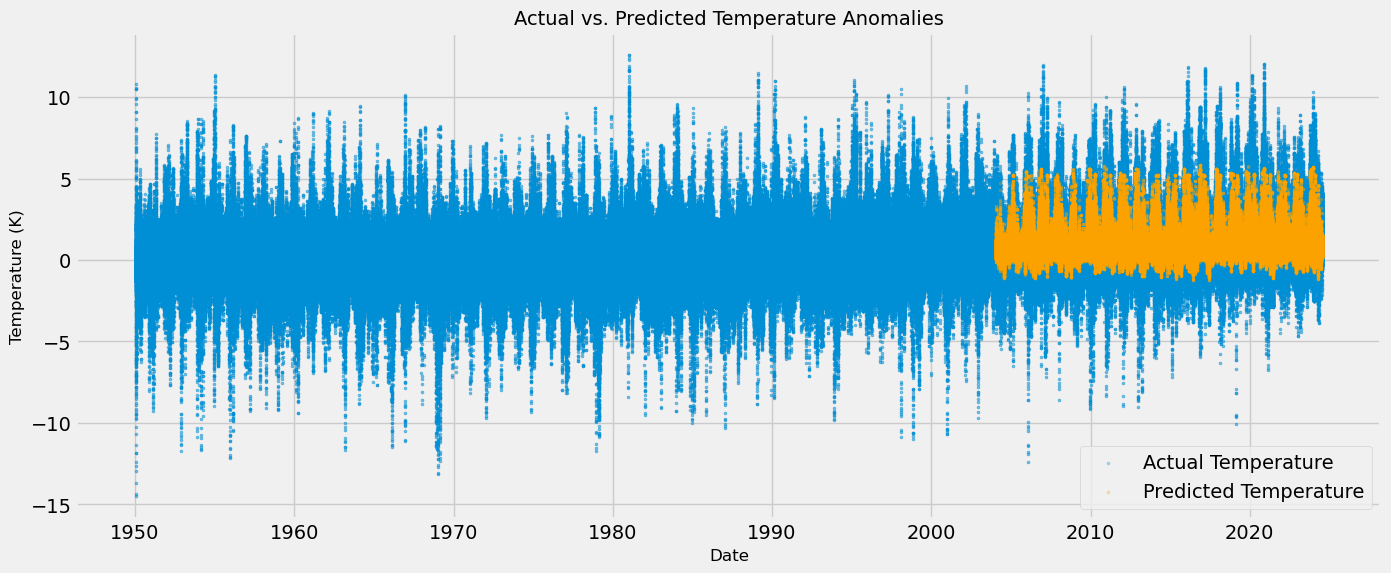

In [39]:
fig, ax = plt.subplots(figsize=figsize)

# Plot the actual temperature anomalies. 
ax.scatter(df.index, df[TARGET], label='Actual Temperature', s=scatter_size, alpha=scatter_alpha)

# Plot the actual predicted temperature anomalies. 
ax.scatter(test.index, test["prediction"], label='Predicted Temperature', color='orange', s=scatter_size, alpha=scatter_alpha)

ax.set_xlabel('Date', fontsize=labelsize)
ax.set_ylabel('Temperature (K)', fontsize=labelsize)
plt.title('Actual vs. Predicted Temperature Anomalies', fontsize=titlesize)
plt.legend(loc="lower right")
plt.show()

#### Focus on the overlapping time period. 

In [40]:
# Define the starting date for filtering the data
date_to_plot_from = "01-01-2010"

# Filter the DataFrame 'df' to include only rows with an index greater than or equal to the starting date
df_filtered = df[df.index >= date_to_plot_from]

# Similarly, filter the 'test' DataFrame to include only rows with an index greater than or equal to the starting date
test_filtered = test[test.index >= date_to_plot_from]

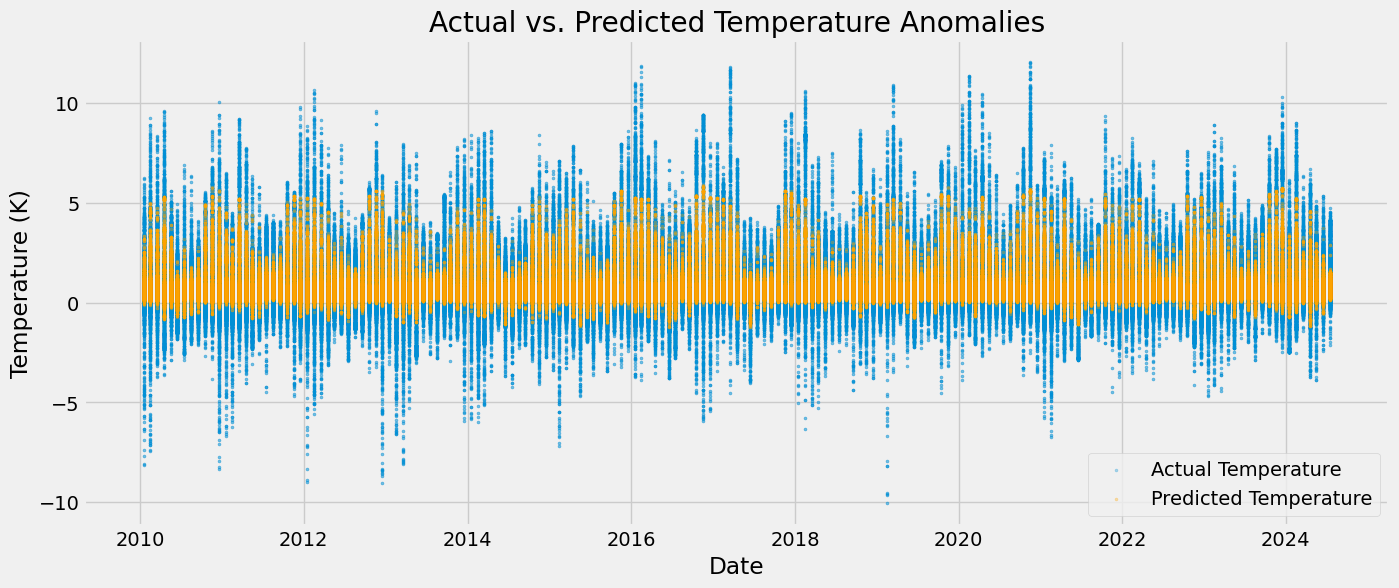

In [41]:
plt.figure(figsize=figsize)
plt.scatter(df_filtered.index, df_filtered[TARGET], label='Actual Temperature', s=scatter_size, alpha=scatter_alpha)
plt.scatter(test_filtered.index, test_filtered["prediction"], label='Predicted Temperature', color='orange', s=scatter_size, alpha=scatter_alpha)
plt.xlabel('Date')
plt.ylabel('Temperature (K)')
plt.title('Actual vs. Predicted Temperature Anomalies')
plt.legend(loc="lower right")
plt.show()

## Next Steps

The graph above demonstrates that we are able to predict a similar anomalie shape for this period, but we are struggling to represent the extreme values. Consider how you could modify this project to improve the result. 

* **Feature Engineering:**
    * Create new features that might capture the behavior of extreme values better.
    * Transform existing features using techniques like log transformation, square root transformation, or binning to reduce the impact of extreme values.
    * Manipulate the bias of the dataset to include more extreme values.

* **Hyperparameter Tuning:**
    * Adjust the learning rate: A lower learning rate can help the model learn more slowly and potentially capture extreme values better.
    * Increase the number of trees: More trees can help the model capture more complex patterns.
    * Tune the max depth and min child weight: These parameters control the complexity of the model and can help in capturing extreme values.
    * Handling Outliers.

* **Ensemble Methods:**
    * Combine multiple models: Use techniques like stacking or blending to combine the predictions of multiple models. This can help in capturing extreme values better.
    * Use different algorithms: Combine XGBoost with other algorithms like Random Forests or Neural Networks to improve performance on extreme values.

* **Regularization:**
    * Adjust regularization parameters: XGBoost has parameters like alpha (L1 regularization) and lambda (L2 regularization) that can be tuned to improve model performance.
    * Resampling Techniques:
    * Oversample or undersample: If extreme values are rare, you can oversample these cases or undersample the more common cases to balance the dataset.
    * Synthetic data generation: Use techniques like SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic examples of extreme values.

* **Advanced Techniques:**
    * Gradient Boosting with Quantile Loss: Instead of using the default loss function, you can use quantile loss to better capture extreme values.
    * Anomaly Detection: Use anomaly detection techniques to identify and treat extreme values separately.

* **Cross-Validation:**
    * Use cross-validation to ensure that your model is not overfitting and is generalizing well to unseen data, including extreme values.

## Time Series Cross Validation Example

TimeSeriesSplit is a cross-validation technique specifically designed for time series data. It ensures that the training and test sets are sequential, which is crucial for time series data where the order of observations matters such as this. Here is an example of how you could use this.

In [42]:
# Import sklearn's TimeSeriesSplit funcitonality to facilitate this process. 
from sklearn.model_selection import TimeSeriesSplit

In [43]:
df.columns

Index(['latitude', 'longitude', 'tas_mean', 'month', 'quarter', 'year', 'lag1',
       'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9',
       'lag10'],
      dtype='object')

In [ ]:
# Initialize TimeSeriesSplit with 4 splits, a test size of 100 years (assuming hourly data), and a gap of 24 hours
tss = TimeSeriesSplit(n_splits=4, test_size= 24*365*100, gap=24)

# Check the DataFrame is sorted by date index to ensure the time series order is correct
df = df.sort_index()

# Display the TimeSeriesSplit object to confirm its configuration
tss

In [ ]:
# Create a list of Features and a variable to store the target. 
FEATURES = ["latitude", "longitude", "lag1" , "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "lag8", "lag9", "lag10", "month"]
TARGET = "tas_mean"

# Create an X_test DataFrame storing our feature columns using the test data (data from before the time split)
X_test = test[FEATURES]

# Create a y_test DataFrame storing our target variable column using the test data (data from before the time split)
y_test = test[TARGET]

### Visualise the Time Series Split

In [ ]:
# Visualise what the Time Series Split does. 

# Create a figure with 4 subplots arranged vertically, sharing the x-axis
fig, axs = plt.subplots(4, 1, figsize = figsize, sharex=True)


# Initialize the fold counter
fold = 0

# Iterate over each train/test split generated by TimeSeriesSplit
for train_index, val_index in tss.split(df):
    
    train = df.iloc[train_index]    # Select training data based on the current split indices
    test = df.iloc[val_index]       # Select test data based on the current split indices
    
    # Plot the training data for the current fold
    train[TARGET].plot(ax=axs[fold],
                     label="Training Set",
                     title=f"Data Train / Test Split Fold {fold}")
    test[TARGET].plot(ax=axs[fold], label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1

plt.xlabel("Time")
plt.ylabel("Temperature K")
plt.show()


### Cross Validation Training Example

In [ ]:
# Sort the DataFrame by its index to ensure the time series data is in chronological order. 
df = df.sort_index()

fold = 0       # Initialize a counter to track the number of folds.
preds = []     # Create an empty list to store predictions from each fold.
scores = []    # Create an empty list to store the RMSE scores from each fold.

run_cross_validation_training = True

if run_cross_validation_training:
    # Loop over the splits generated by TimeSeriesSplit.
    for train_index, val_index in tss.split(df):
        print(f"Training fold number: {fold}")
        train = df.iloc[train_index]      # Select the training data based on the current split indices.
        test = df.iloc[val_index]         # Select the validation data based on the current split indices.

        train = create_features(train)    # Apply feature engineering to the training data.
        test = create_features(test)      # Apply feature engineering to the validation data.

        X_train = train[FEATURES]  # Extract the feature columns from the training data (pre date split).
        y_train = train[TARGET]    # Extract the target column from the training data (pre date split).

        X_test = test[FEATURES]  # Extract the feature columns from the validation data (post date split).
        y_test = test[TARGET]    # Extract the target column from the validation data (post date split).


    # Initialize the XGBoost regressor with specified hyperparameters.
        reg = xgb.XGBRegressor(base_score=0.5, 
                               booster="gbtree", 
                               n_estimators=1000, 
                               early_stopping_rounds=50, 
                               objective="reg:squarederror", 
                               max_depth=3, 
                               learning_rate=0.01)

        # Train the model on the training data.
        reg.fit(X_train, y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
               verbose=100)

        # Make predictions on the validation data.
        y_pred = reg.predict(X_test)

        # Append the predictions to the list.
        preds.append(y_pred)   

        # Calculate the RMSE for the current fold.
        score = np.sqrt(mean_squared_error(y_test, y_pred)) 

        # Append the RMSE score to the list.
        scores.append(score)    

        # Increment the fold counter
        fold += 1
        
    # Print the average mean score for all folds and the individual score for each fold. 

    print(f"Average score across folds {np.mean(scores): 0.4f}")
    print(f"Fold scores: {scores}")
